# Redes neuronales con Scikit Learn

In [28]:
# Cargamos librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plt.style.use('fivethirtyeight')


from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

import warnings
warnings.filterwarnings('ignore')


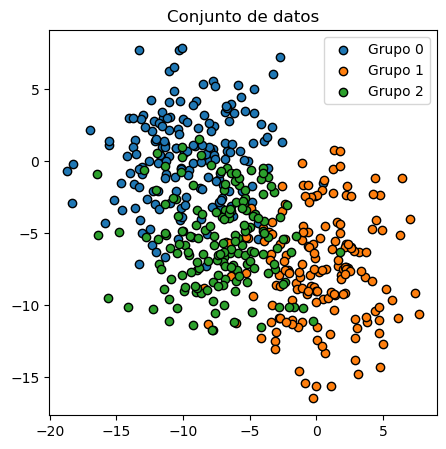

In [35]:
# Creamos un set de datos con 3 categorías de datos (sin separación perfecta)
X, y = make_blobs(
        n_samples    = 500, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 3.2, 
        shuffle      = True, 
        random_state = 9
       )

fig, ax = plt.subplots(1, 1, figsize=(5, 5))


for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax.set_title('Conjunto de datos')
ax.legend();

### Creamos 4 modelos cada uno más complejo que el anterior (en neuronas y capas)

In [36]:
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(5),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_1.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=5, learning_rate_init=0.01, max_iter=1000,
              random_state=123, solver='lbfgs')

In [37]:
modelo_2 = MLPClassifier(
                hidden_layer_sizes=(10),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_2.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.01, max_iter=1000,
              random_state=123, solver='lbfgs')

In [38]:
modelo_3 = MLPClassifier(
                hidden_layer_sizes=(20, 20),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_3.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

In [39]:
modelo_4 = MLPClassifier(
                hidden_layer_sizes=(50, 50, 50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

### Pintamos los modelos obtenidos junto con los datos

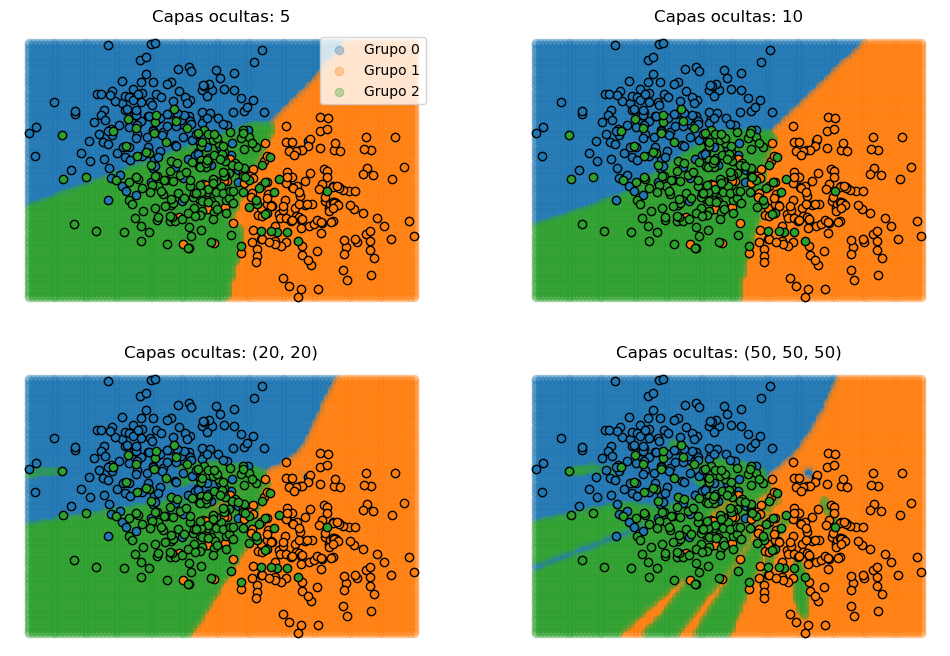

In [40]:
# Generamos el marco para los gráficos (4)
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs = axs.flatten()

# Pintamos los ejes
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(
            x = X_grid[predicciones == j, 0],
            y = X_grid[predicciones == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            #marker = 'o',
            alpha = 0.3,
            label= f"Grupo {j}"
        )

    for j in np.unique(y):
        axs[i].scatter(
            x = X[y == j, 0],
            y = X[y == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            marker    = 'o',
            edgecolor = 'black'
        )
        
    axs[i].set_title(f"Capas ocultas: {modelo.hidden_layer_sizes}")
    axs[i].axis('off')
axs[0].legend();


A medida que aumenta la complejidad de las RNA, las fronteras de decisión se adaptan mejor a los datos.
Hemos cogido los hiperparámetros que hemos creído convenientes, ¿pero son los correctos?

### Búsqueda de hiperparámetros óptimos

#### Comprobamos cómo se comporta la red ante cambios en el número de neuronas

In [41]:
param_grid = {'hidden_layer_sizes':[1, 5, 7, 10, 15, 25, 50]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

grid.fit(X, y)


GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0, learning_rate_init=0.01,
                                     max_iter=5000, random_state=123,
                                     solver='lbfgs'),
             param_grid={'hidden_layer_sizes': [1, 5, 7, 10, 15, 25, 50]},
             return_train_score=True, scoring='accuracy')

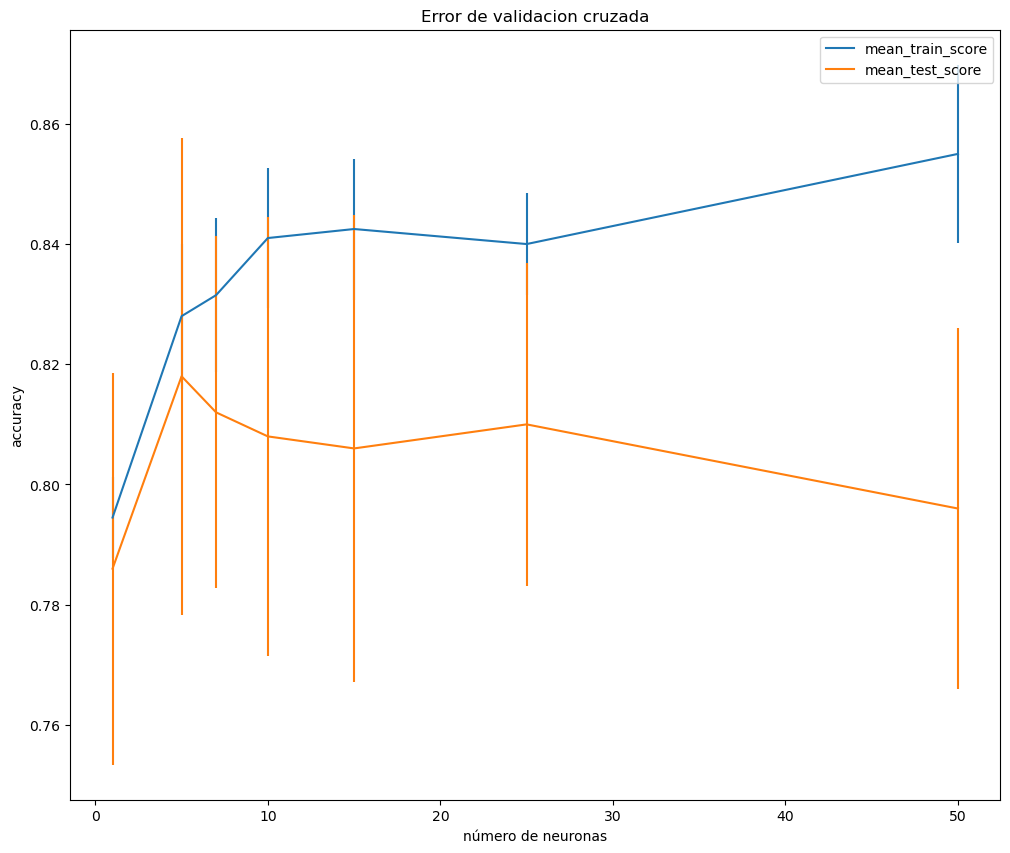

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

#### ¿Y frente a cambios en el ratio de aprendizaje?

In [43]:
param_grid = {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        hidden_layer_sizes=(10),
                        solver = 'adam',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0, hidden_layer_sizes=10,
                                     max_iter=5000, random_state=123),
             param_grid={'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                                100]},
             return_train_score=True, scoring='accuracy')

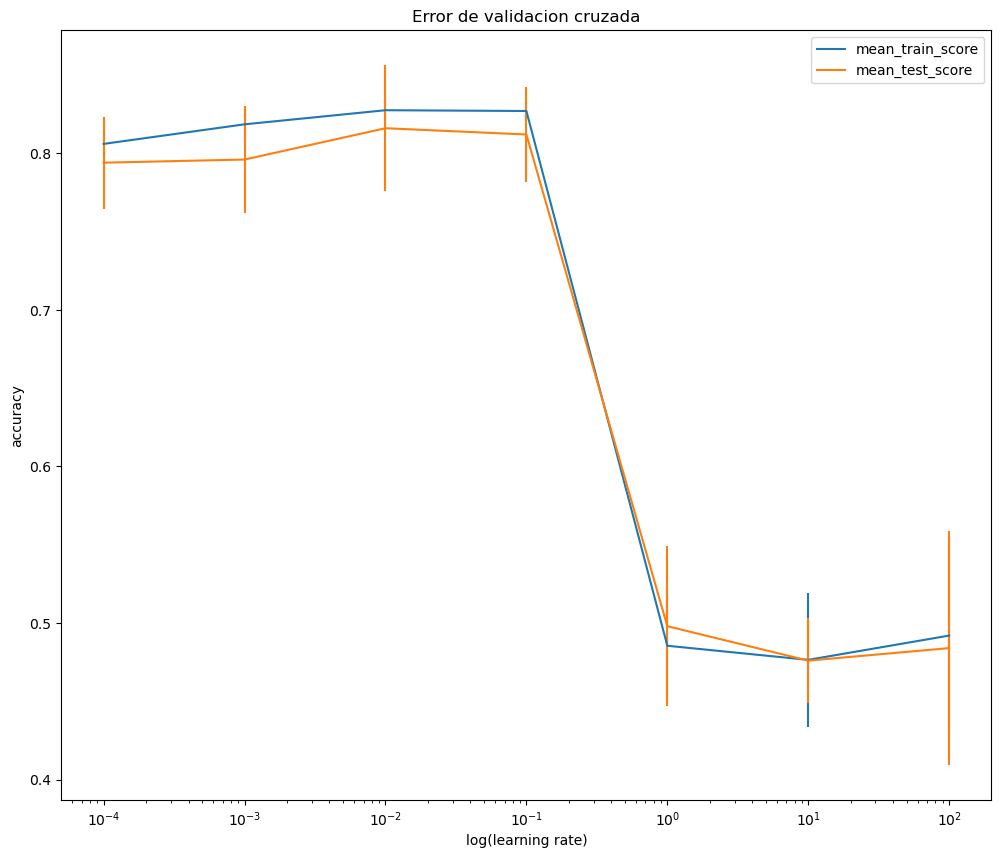

In [44]:
fig, ax = plt.subplots(figsize=(12,10))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validacion cruzada');

Este sistema de búsqueda de hiperparámetros, sólo sirve para hacernos una idea de cómo afecta cada hiperparámetro.  No obstante lo correcto es hacer la búsqueda de hiperparámetros de manera conjunta.  Puesto que el proceso puede ser extremadamente costoso computacionalmente, se hace una búsqueda de hiperparámetros aleatoria dentro de los rangos que hayamos definido.

In [45]:
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Búsqueda de hiperparámetros por validación cruzada aleatoriamente
grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 5000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )


grid.fit(X = X, y = y)

# Resultados de la malla
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
49,0.1,10,100.0,0.817966,0.027168,0.827004,0.010142
46,0.01,10,100.0,0.817966,0.027168,0.826006,0.010589
16,0.1,"(10, 10)",0.001,0.815995,0.031839,0.842996,0.019851
11,0.001,10,1.0,0.815970,0.033451,0.834994,0.015376
18,0.001,"(10, 10)",1.0,0.815958,0.032809,0.839993,0.012185
30,0.01,10,10.0,0.815958,0.028521,0.827999,0.008634
3,0.01,"(10, 10)",1.0,0.811966,0.022877,0.850006,0.015253
34,0.1,"(10, 10)",10.0,0.811966,0.027175,0.829995,0.014003
21,0.1,"(20, 20)",10.0,0.811954,0.031352,0.828988,0.015044
4,0.01,"(20, 20)",10.0,0.811954,0.031352,0.828994,0.010783


In [46]:
# Mejores hiperparámetros...
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=100.0, hidden_layer_sizes=10, learning_rate_init=0.01,
              max_iter=5000, solver='lbfgs')

### Pintamos el resultado

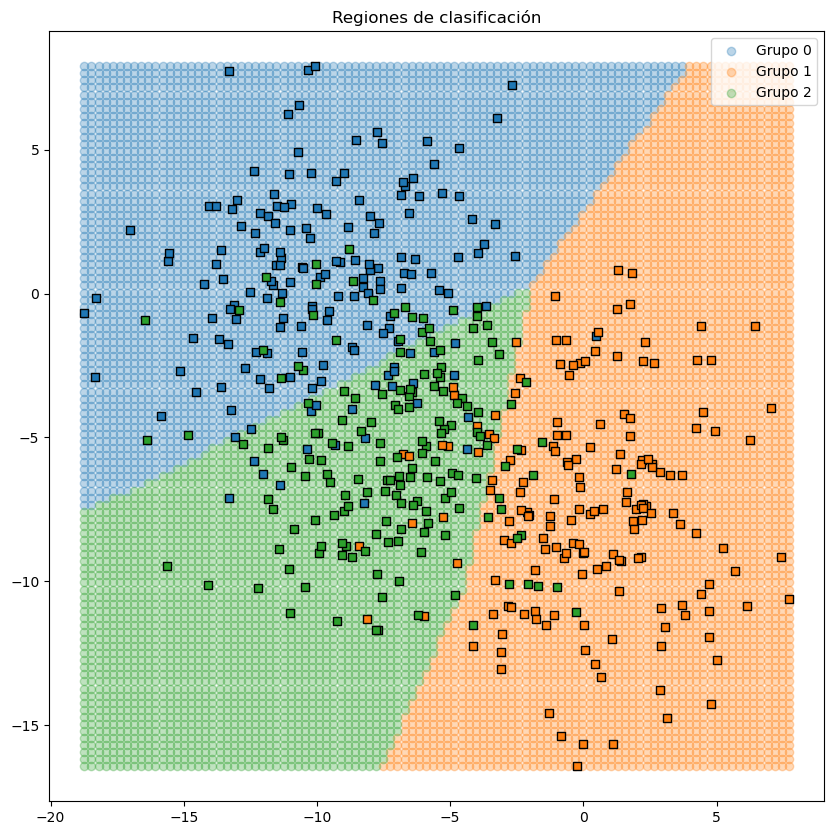

In [47]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])
predicciones = modelo.predict(X_grid)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        #marker = 'o',
        alpha = 0.3,
        label= f"Grupo {i}"
    )

for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 's',
        edgecolor = 'black'
    )
    

ax.set_title('Regiones de clasificación')
ax.legend();
